#Analisis de Problema

#Librerias

In [ ]:
!pip install tensorflow==2.12.0

  Using cached tensorflow-2.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
  Using cached keras-2.12.0-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
  Using cached protobuf-4.25.8-cp37-abi3-manylinux2014_x86_64.whl.metadata (541 bytes)
  Using cached tensorboard-2.12.3-py3-none-any.whl.metadata (1.8 kB)
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
  Using cached jax-0.6.1-py3-none-any.whl.metadata (13 kB)
  Using cached jaxlib-0.6.1-cp311-cp311-manylinux2014_x86_64.whl.metadata (1.2 kB)
  Using cached jax-0.6.0-py3-none-any.whl.metadata (22 kB)
  Using cached jaxlib-0.6.0-cp311-cp311-manylinux2014_x86_64.whl.metadata (1.2 kB)
  Using cached jax-0.5.3-py3-none-any.whl.metadata (22 kB)
  Using cached jaxlib-0.5.3-cp311-cp311-manylinux2014_x86_64.whl.metadata (1.2 

In [ ]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Activation, MaxPooling2D, Flatten

import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D,SeparableConv2D
from tensorflow import keras
from tensorflow.keras import layers
import time
from keras.models import load_model
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score,ConfusionMatrixDisplay,classification_report

import itertools
import os
import dlib
import cv2
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import datetime
import plotly.express as px
from random import random
from IPython.display import display, Javascript
from base64 import b64decode
from numpy import argmax

%load_ext tensorboard

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
tf.config.experimental.set_visible_devices([], 'GPU')

In [ ]:
tf.__version__

'2.12.0'

# Entendimiento de los Datos

In [ ]:
!pip install roboflow

# Importamos librerías clave
from roboflow import Roboflow

In [ ]:
# Conectamos con Roboflow
rf = Roboflow(api_key="uuDrRwgrAxZYNsnhkcsv")
project = rf.workspace("proyecto-ia-sb8s4").project("amputations")
version = project.version(1)

# Descargamos el dataset en formato YOLOv8
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Amputations-1 in yolov8:: 100%|██████████| 1496/1496 [00:00<00:00, 8269.77it/s]


In [ ]:
pip install opencv-python pyyaml


In [ ]:
import os
import cv2          # solo si quieres verificar con imread; para copiar basta shutil
import shutil
import yaml
from glob import glob

# --- 1. Paths --------------------------------------------------------
dataset_dir  = "Amputations-1/train"
images_dir   = os.path.join(dataset_dir, "images")
labels_dir   = os.path.join(dataset_dir, "labels")
output_dir   = "classification_dataset"

os.makedirs(output_dir, exist_ok=True)

# --- 2. Cargar nombres de clase desde data.yaml ----------------------
with open(os.path.join("Amputations-1", "data.yaml"), "r") as f:
    class_names = yaml.safe_load(f)["names"]

# --- 3. Procesar imágenes -------------------------------------------
image_paths = glob(os.path.join(images_dir, "*.jpg"))          # ajusta extensión si es PNG

for img_path in image_paths:
    filename   = os.path.basename(img_path)
    label_path = os.path.join(labels_dir, filename.replace(".jpg", ".txt"))

    if not os.path.exists(label_path):
        continue  # no hay anotaciones → se ignora

    # --- 3A. Leer los class_id presentes -----------------------------
    with open(label_path, "r") as f:
        class_ids = {int(line.split()[0]) for line in f if line.strip()}  # conjunto único

    # --- 3B. Copiar imagen completa en cada carpeta de clase ---------
    for idx, class_id in enumerate(class_ids):
        class_name = class_names[class_id]
        class_dir  = os.path.join(output_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)

        # Si hay varias clases en la misma imagen, añade sufijo para evitar colisión
        dst_name = (
            f"{filename[:-4]}_{idx}.jpg" if len(class_ids) > 1 else filename
        )
        dst_path = os.path.join(class_dir, dst_name)

        # Copia binaria (conserva EXIF y metadata)
        shutil.copy2(img_path, dst_path)


<Figure size 1000x600 with 0 Axes>

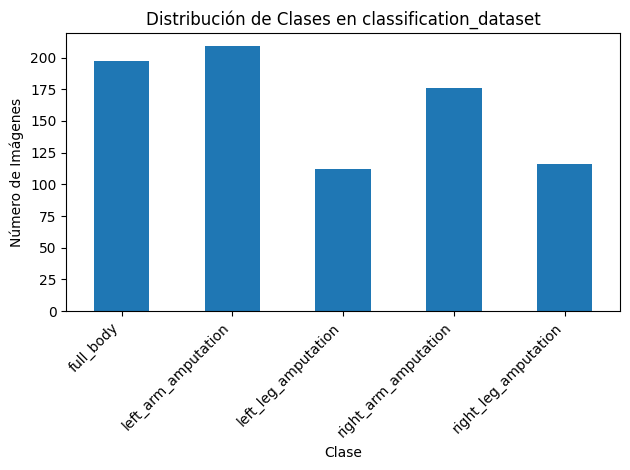

In [ ]:
# prompt: Generame un grafico de barras de classification_dataset

import pandas as pd
import matplotlib.pyplot as plt
import yaml
from glob import glob

# Contar las imágenes por clase en el classification_dataset
class_counts = {}
for class_name in class_names:
    class_dir = os.path.join(output_dir, class_name)
    if os.path.exists(class_dir):
        image_count = len(glob(os.path.join(class_dir, "*.jpg")))
        class_counts[class_name] = image_count

# Crear un DataFrame de pandas para facilitar la visualización
df_class_counts = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Count'])
df_class_counts = df_class_counts.sort_index() # Opcional: ordenar por nombre de clase

# Generar el gráfico de barras
plt.figure(figsize=(10, 6))
df_class_counts.plot(kind='bar', legend=False)
plt.title('Distribución de Clases en classification_dataset')
plt.xlabel('Clase')
plt.ylabel('Número de Imágenes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
import os

datasetDirectory = "/content/classification_dataset"

categories = []
for folder in sorted(os.listdir(datasetDirectory)):
    folder_path = os.path.join(datasetDirectory, folder)
    if os.path.isdir(folder_path):
        print(folder)
        categories.append(folder)

lenCategories = len(categories)
print(f"\nTotal de categorías detectadas: {lenCategories}")

full_body
left_arm_amputation
left_leg_amputation
right_arm_amputation
right_leg_amputation

Total de categorías detectadas: 5


In [ ]:
img_size = 256
X, y = [], []

for category in categories:
    path = os.path.join(datasetDirectory, category)
    label = categories.index(category)

    for img_name in os.listdir(path):
        try:
            img   = cv2.imread(os.path.join(path, img_name))
            img   = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img   = cv2.resize(img, (img_size, img_size))
            X.append(img)
            y.append(label)
        except Exception as e:
            print('err', e)

X = np.array(X, dtype='float32')
y = np.array(y)


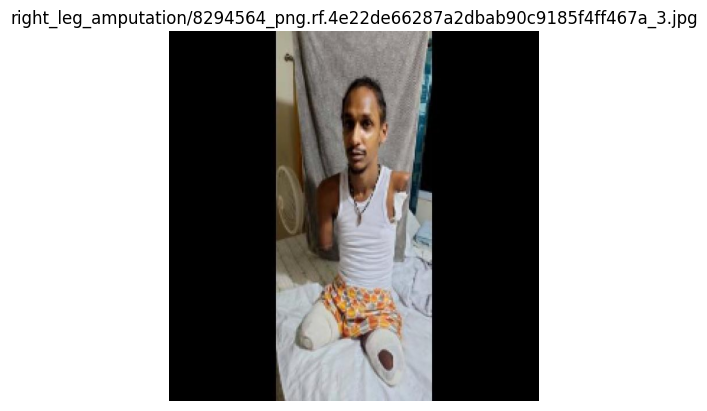

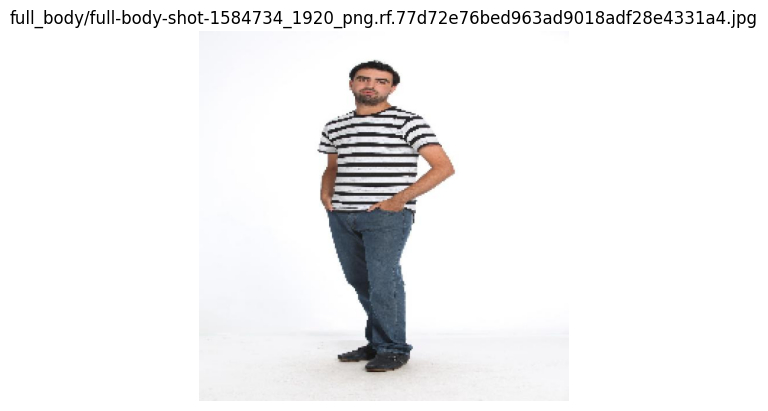

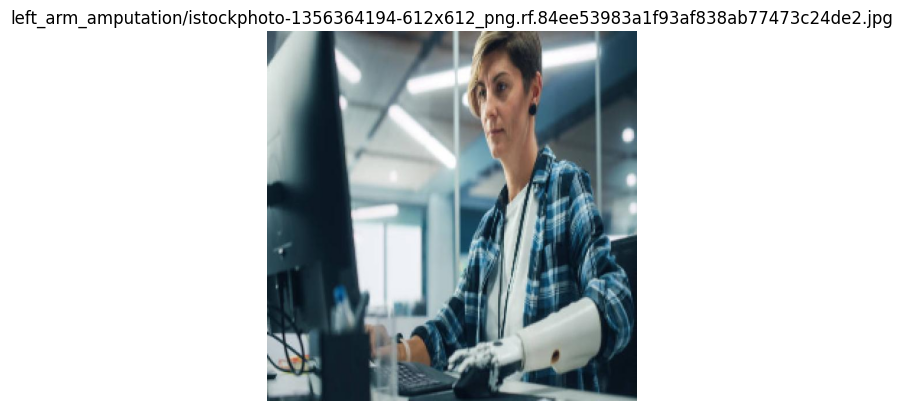

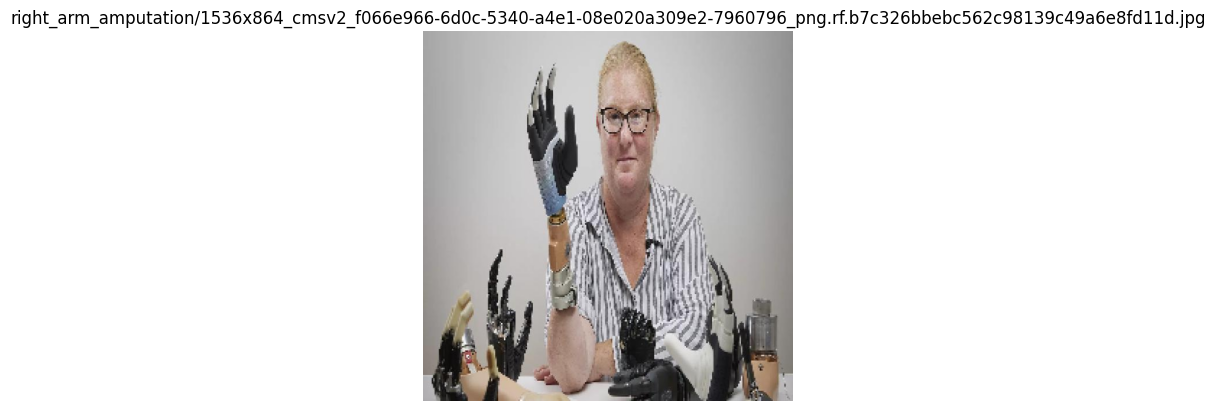

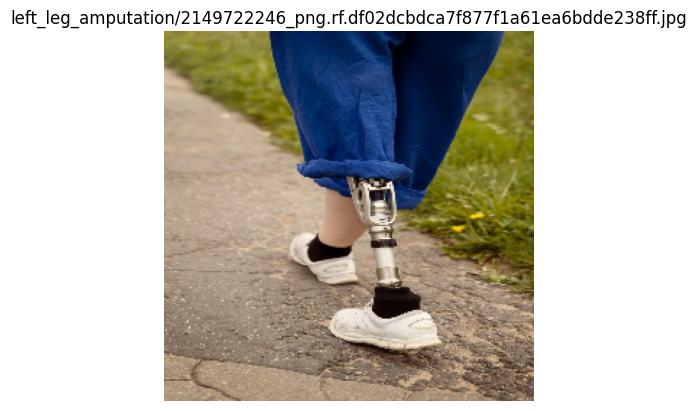

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

datasetDirectory = "/content/classification_dataset"

for path, subdirs, files in os.walk(datasetDirectory):
    shown = False
    for file in files:
        img_path = os.path.join(path, file)
        img = cv2.imread(img_path)
        if img is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img_rgb)
            plt.title(f"{os.path.basename(path)}/{file}")
            plt.axis('off')
            plt.show()
            shown = True
            break

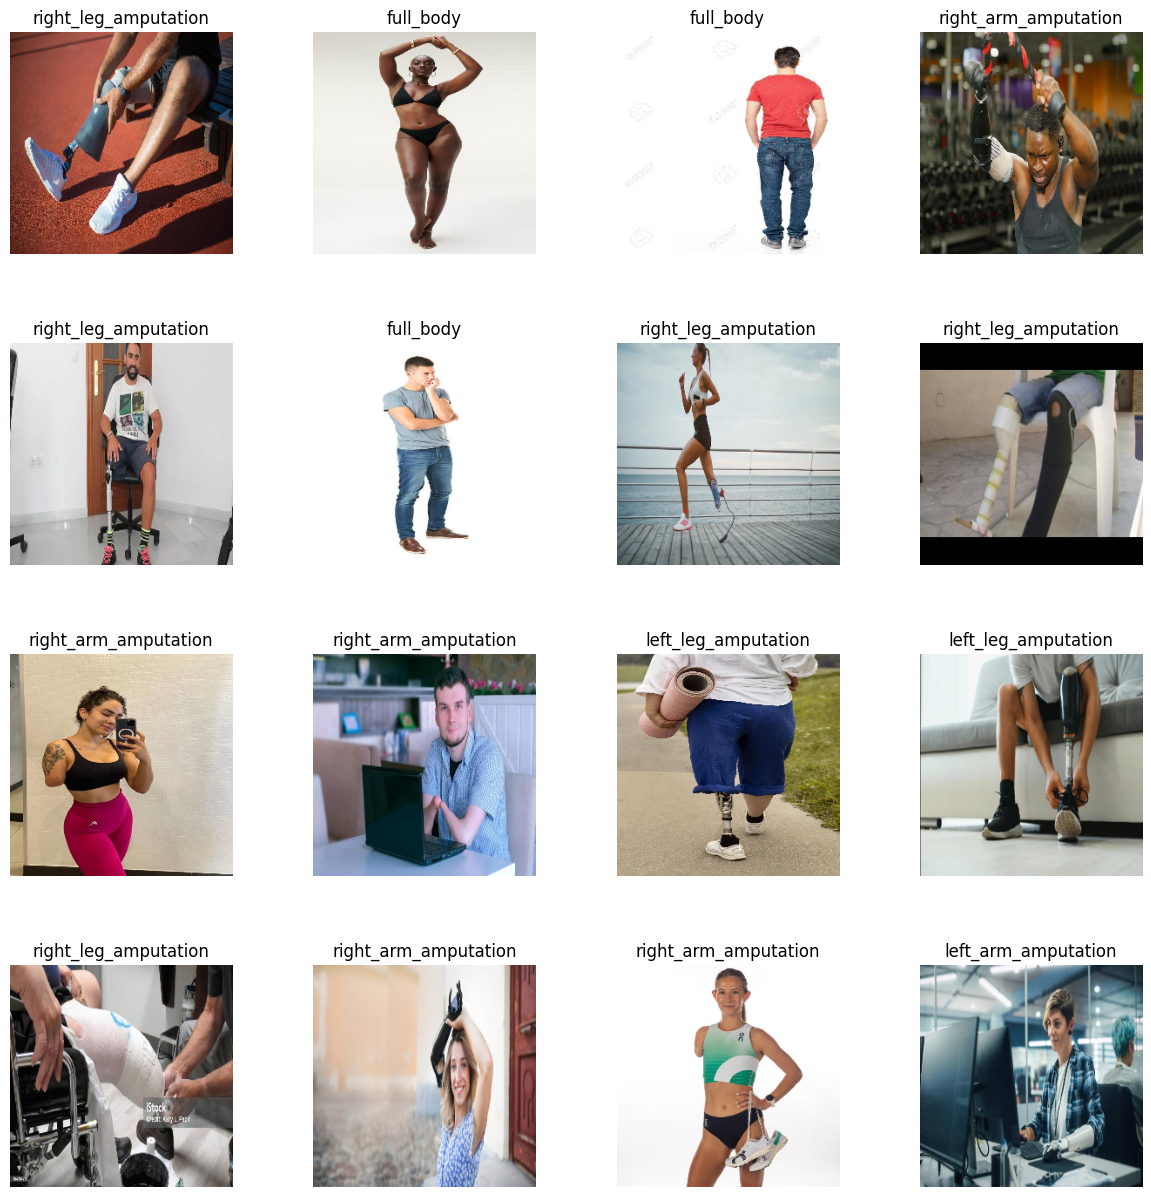

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

W_grid = 4
L_grid = 4

fig, axes = plt.subplots(L_grid, W_grid, figsize=(15, 15))
axes = axes.ravel()

n_samples = len(X)

for i in range(L_grid * W_grid):
    index = np.random.randint(0, n_samples)
    image = X[index].astype(np.uint8)
    label = categories[y[index]]

    axes[i].imshow(image)
    axes[i].set_title(label)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)
plt.show()


#Exploración de los datos

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=0, stratify=y)


In [ ]:
num_classes = len(categories)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test,  num_classes)

In [ ]:
import numpy as np
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
)


one_hot = (y_train.ndim > 1)
labels  = y_train if not one_hot else np.argmax(y_train, axis=1)


class_counts = Counter(labels)
max_count    = max(class_counts.values())


aug_imgs, aug_lbls = [], []

for cls, count in class_counts.items():
    n_needed = max_count - count
    if n_needed == 0:
        continue

    idx   = np.where(labels == cls)[0]
    X_cls = X_train[idx]
    y_cls = y_train[idx]

    gen = datagen.flow(X_cls, y_cls, batch_size=32, shuffle=True)
    generated = 0

    while generated < n_needed:
        x_batch, y_batch = next(gen)
        remain = n_needed - generated
        if remain < len(x_batch):
            x_batch = x_batch[:remain]
            y_batch = y_batch[:remain]
        aug_imgs.append(x_batch)
        aug_lbls.append(y_batch)
        generated += len(x_batch)

X_train = np.concatenate([X_train] + aug_imgs, axis=0)
y_train = np.concatenate([y_train] + aug_lbls, axis=0)

perm = np.random.permutation(len(X_train))
X_train = X_train[perm]
y_train = y_train[perm]


if y_train.ndim == 1:
    y_train = keras.utils.to_categorical(y_train, lenCategories)

if y_test.ndim == 1:
    y_test = keras.utils.to_categorical(y_test, lenCategories)

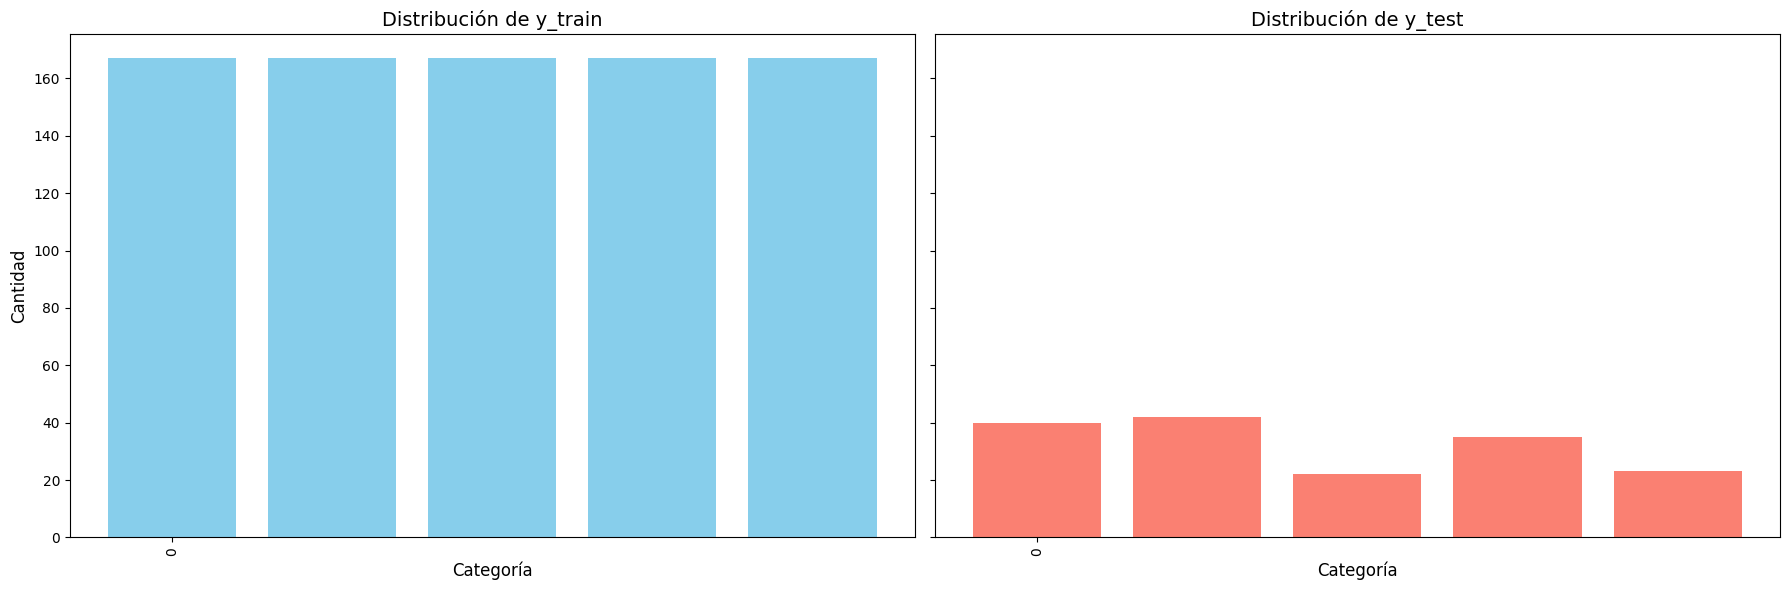

In [ ]:
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)


train_counts = np.bincount(y_train_labels, minlength=lenCategories)
test_counts = np.bincount(y_test_labels, minlength=lenCategories)


fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)


axes[0].bar(np.arange(lenCategories), train_counts, color="skyblue")
axes[0].set_title("Distribución de y_train", fontsize=14)
axes[0].set_xlabel("Categoría", fontsize=12)
axes[0].set_ylabel("Cantidad", fontsize=12)
axes[0].set_xticks(np.arange(0, lenCategories, 5))
axes[0].tick_params(axis='x', rotation=90)


axes[1].bar(np.arange(lenCategories), test_counts, color="salmon")
axes[1].set_title("Distribución de y_test", fontsize=14)
axes[1].set_xlabel("Categoría", fontsize=12)
axes[1].set_xticks(np.arange(0, lenCategories, 5))
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


#Modelo


In [ ]:
def plot_learning_curve(history):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.title('Precisión del modelo')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title('Pérdida del modelo')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
from tensorflow.keras.callbacks import Callback
import numpy as np

class MetricsCheckpoint(Callback):
    """
    Callback que guarda las métricas de entrenamiento en un archivo .npy por época.
    """
    def __init__(self, savepath):
        super().__init__()
        self.savepath = savepath
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matriz de confusión',
                          cmap=plt.cm.Blues,
                          show_text=False):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    fig, ax = plt.subplots(figsize=(20, 20))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title, fontsize=18)
    fig.colorbar(im, fraction=0.046, pad=0.04)

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes, rotation=90, fontsize=7)
    ax.set_yticklabels(classes, fontsize=7)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if show_text:
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            text = f"{cm[i, j]:.2f}" if normalize else f"{cm[i, j]}"
            ax.text(j, i, text,
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=5)

    ax.set_ylabel('Etiqueta verdadera', fontsize=14)
    ax.set_xlabel('Etiqueta predicha', fontsize=14)
    plt.tight_layout()
    plt.grid(False)
    plt.show()

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import numpy as np, os

def runEffB0_finetune(Xtr, Ytr, Xtest, Ytest, num_classes,
                      head_epochs=10, ft_epochs=10, batch=64):

    # ---------- 0. Paths ----------
    os.makedirs("checkpoints", exist_ok=True)

    # ---------- 1. Data Aug ----------
    datagen = ImageDataGenerator(
        rotation_range=35,
        width_shift_range=0.25, height_shift_range=0.25,
        zoom_range=0.3, shear_range=15,
        brightness_range=[0.7, 1.3],
        horizontal_flip=True, fill_mode="nearest"
    )

    # ---------- 2. Class weights ----------
    y_int = np.argmax(Ytr, axis=1)
    cw = dict(enumerate(
        compute_class_weight('balanced', classes=np.unique(y_int), y=y_int)
    ))

    # ---------- 3. Base model ----------
    h, w, c = Xtr.shape[1:]
    base = EfficientNetB0(weights='imagenet', include_top=False,
                          input_shape=(h, w, c))
    for layer in base.layers[:-30]:
        layer.trainable = False

    # ---------- 4. Head ----------
    inp = Input(shape=(h, w, c))
    x   = base(inp, training=False)
    x   = GlobalAveragePooling2D()(x)
    x   = Dropout(0.5)(x)                 # ← Dropout mayor
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(inp, out)

    # ---------- 5. Callbacks HEAD ----------
    cb_head = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                          patience=2, min_lr=1e-6),
        ModelCheckpoint(
            filepath='checkpoints/head_epoch_{epoch:02d}_valacc_{val_accuracy:.3f}.h5',
            save_weights_only=True, save_freq='epoch',
            monitor='val_accuracy', save_best_only=False)
    ]

    model.compile(optimizer=Adam(1e-3),
                  loss='categorical_crossentropy', metrics=['accuracy'])

    hist_head = model.fit(
        datagen.flow(Xtr, Ytr, batch_size=batch),
        steps_per_epoch=len(Xtr)//batch, epochs=head_epochs,
        validation_data=(Xtest, Ytest),
        class_weight=cw, callbacks=cb_head, verbose=2)

    # ---------- 6. Fine-tuning ----------
    base.trainable = True
    for layer in base.layers[:-10]:       # ← se afinan más capas
        layer.trainable = False

    model.compile(optimizer=Adam(1e-4),
                  loss='categorical_crossentropy', metrics=['accuracy'])

    cb_ft = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                          patience=2, min_lr=1e-6),
        ModelCheckpoint(
            filepath='checkpoints/ft_epoch_{epoch:02d}_valacc_{val_accuracy:.3f}.h5',
            save_weights_only=True, save_freq='epoch',
            monitor='val_accuracy', save_best_only=False)
    ]

    hist_ft = model.fit(
        datagen.flow(Xtr, Ytr, batch_size=batch),
        steps_per_epoch=len(Xtr)//batch, epochs=ft_epochs,
        validation_data=(Xtest, Ytest),
        class_weight=cw, callbacks=cb_ft, verbose=2)

    # ---------- 7. Eval ----------
    val_loss, val_acc = model.evaluate(Xtest, Ytest, verbose=0)
    print(f"\n✅ Accuracy validación final: {val_acc:.3f}")

    return model, hist_head, hist_ft


In [ ]:
model, h_head, h_ft = runEffB0_finetune(
    X_train, y_train, X_test, y_test,
    num_classes=lenCategories,
    head_epochs=10, ft_epochs=10, batch=64
)


Epoch 1/10
13/13 - 113s - loss: 1.2348 - accuracy: 0.4669 - val_loss: 1.0978 - val_accuracy: 0.5000 - lr: 0.0010 - 113s/epoch - 9s/step
Epoch 2/10
13/13 - 107s - loss: 0.9369 - accuracy: 0.6122 - val_loss: 0.9625 - val_accuracy: 0.5679 - lr: 0.0010 - 107s/epoch - 8s/step
Epoch 3/10
13/13 - 108s - loss: 0.7562 - accuracy: 0.7004 - val_loss: 0.8748 - val_accuracy: 0.6111 - lr: 0.0010 - 108s/epoch - 8s/step
Epoch 4/10
13/13 - 105s - loss: 0.6500 - accuracy: 0.7276 - val_loss: 0.9035 - val_accuracy: 0.6605 - lr: 0.0010 - 105s/epoch - 8s/step
Epoch 5/10
13/13 - 102s - loss: 0.6159 - accuracy: 0.7588 - val_loss: 0.8454 - val_accuracy: 0.6605 - lr: 0.0010 - 102s/epoch - 8s/step
Epoch 6/10
13/13 - 108s - loss: 0.5992 - accuracy: 0.7717 - val_loss: 0.9359 - val_accuracy: 0.6667 - lr: 0.0010 - 108s/epoch - 8s/step
Epoch 7/10
13/13 - 108s - loss: 0.4768 - accuracy: 0.8067 - val_loss: 0.9326 - val_accuracy: 0.6852 - lr: 0.0010 - 108s/epoch - 8s/step
Epoch 8/10
13/13 - 102s - loss: 0.3752 - accurac

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Suponiendo X_train ya definido
h, w, c = X_train.shape[1:]
base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(h, w, c))
for layer in base.layers[:-10]:
    layer.trainable = False

inp = Input(shape=(h, w, c))
x = base(inp)  # NO uses training=True
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=0.5)(x)  # asegúrate de que no estás pasando tf.Tensor aquí
out = Dense(lenCategories, activation="softmax")(x)

model = Model(inputs=inp, outputs=out)

# 2. Compilar antes de cargar (requerido por Keras)
model.compile(optimizer=Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 3. Cargar pesos fine-tuned
model.load_weights("/content/ft_epoch_07_valacc_0.691.h5")

# 4. Verificar que se cargó bien
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"✔️ Accuracy cargado: {acc:.3f}")


✔️ Accuracy cargado: 0.852


#Evaluación

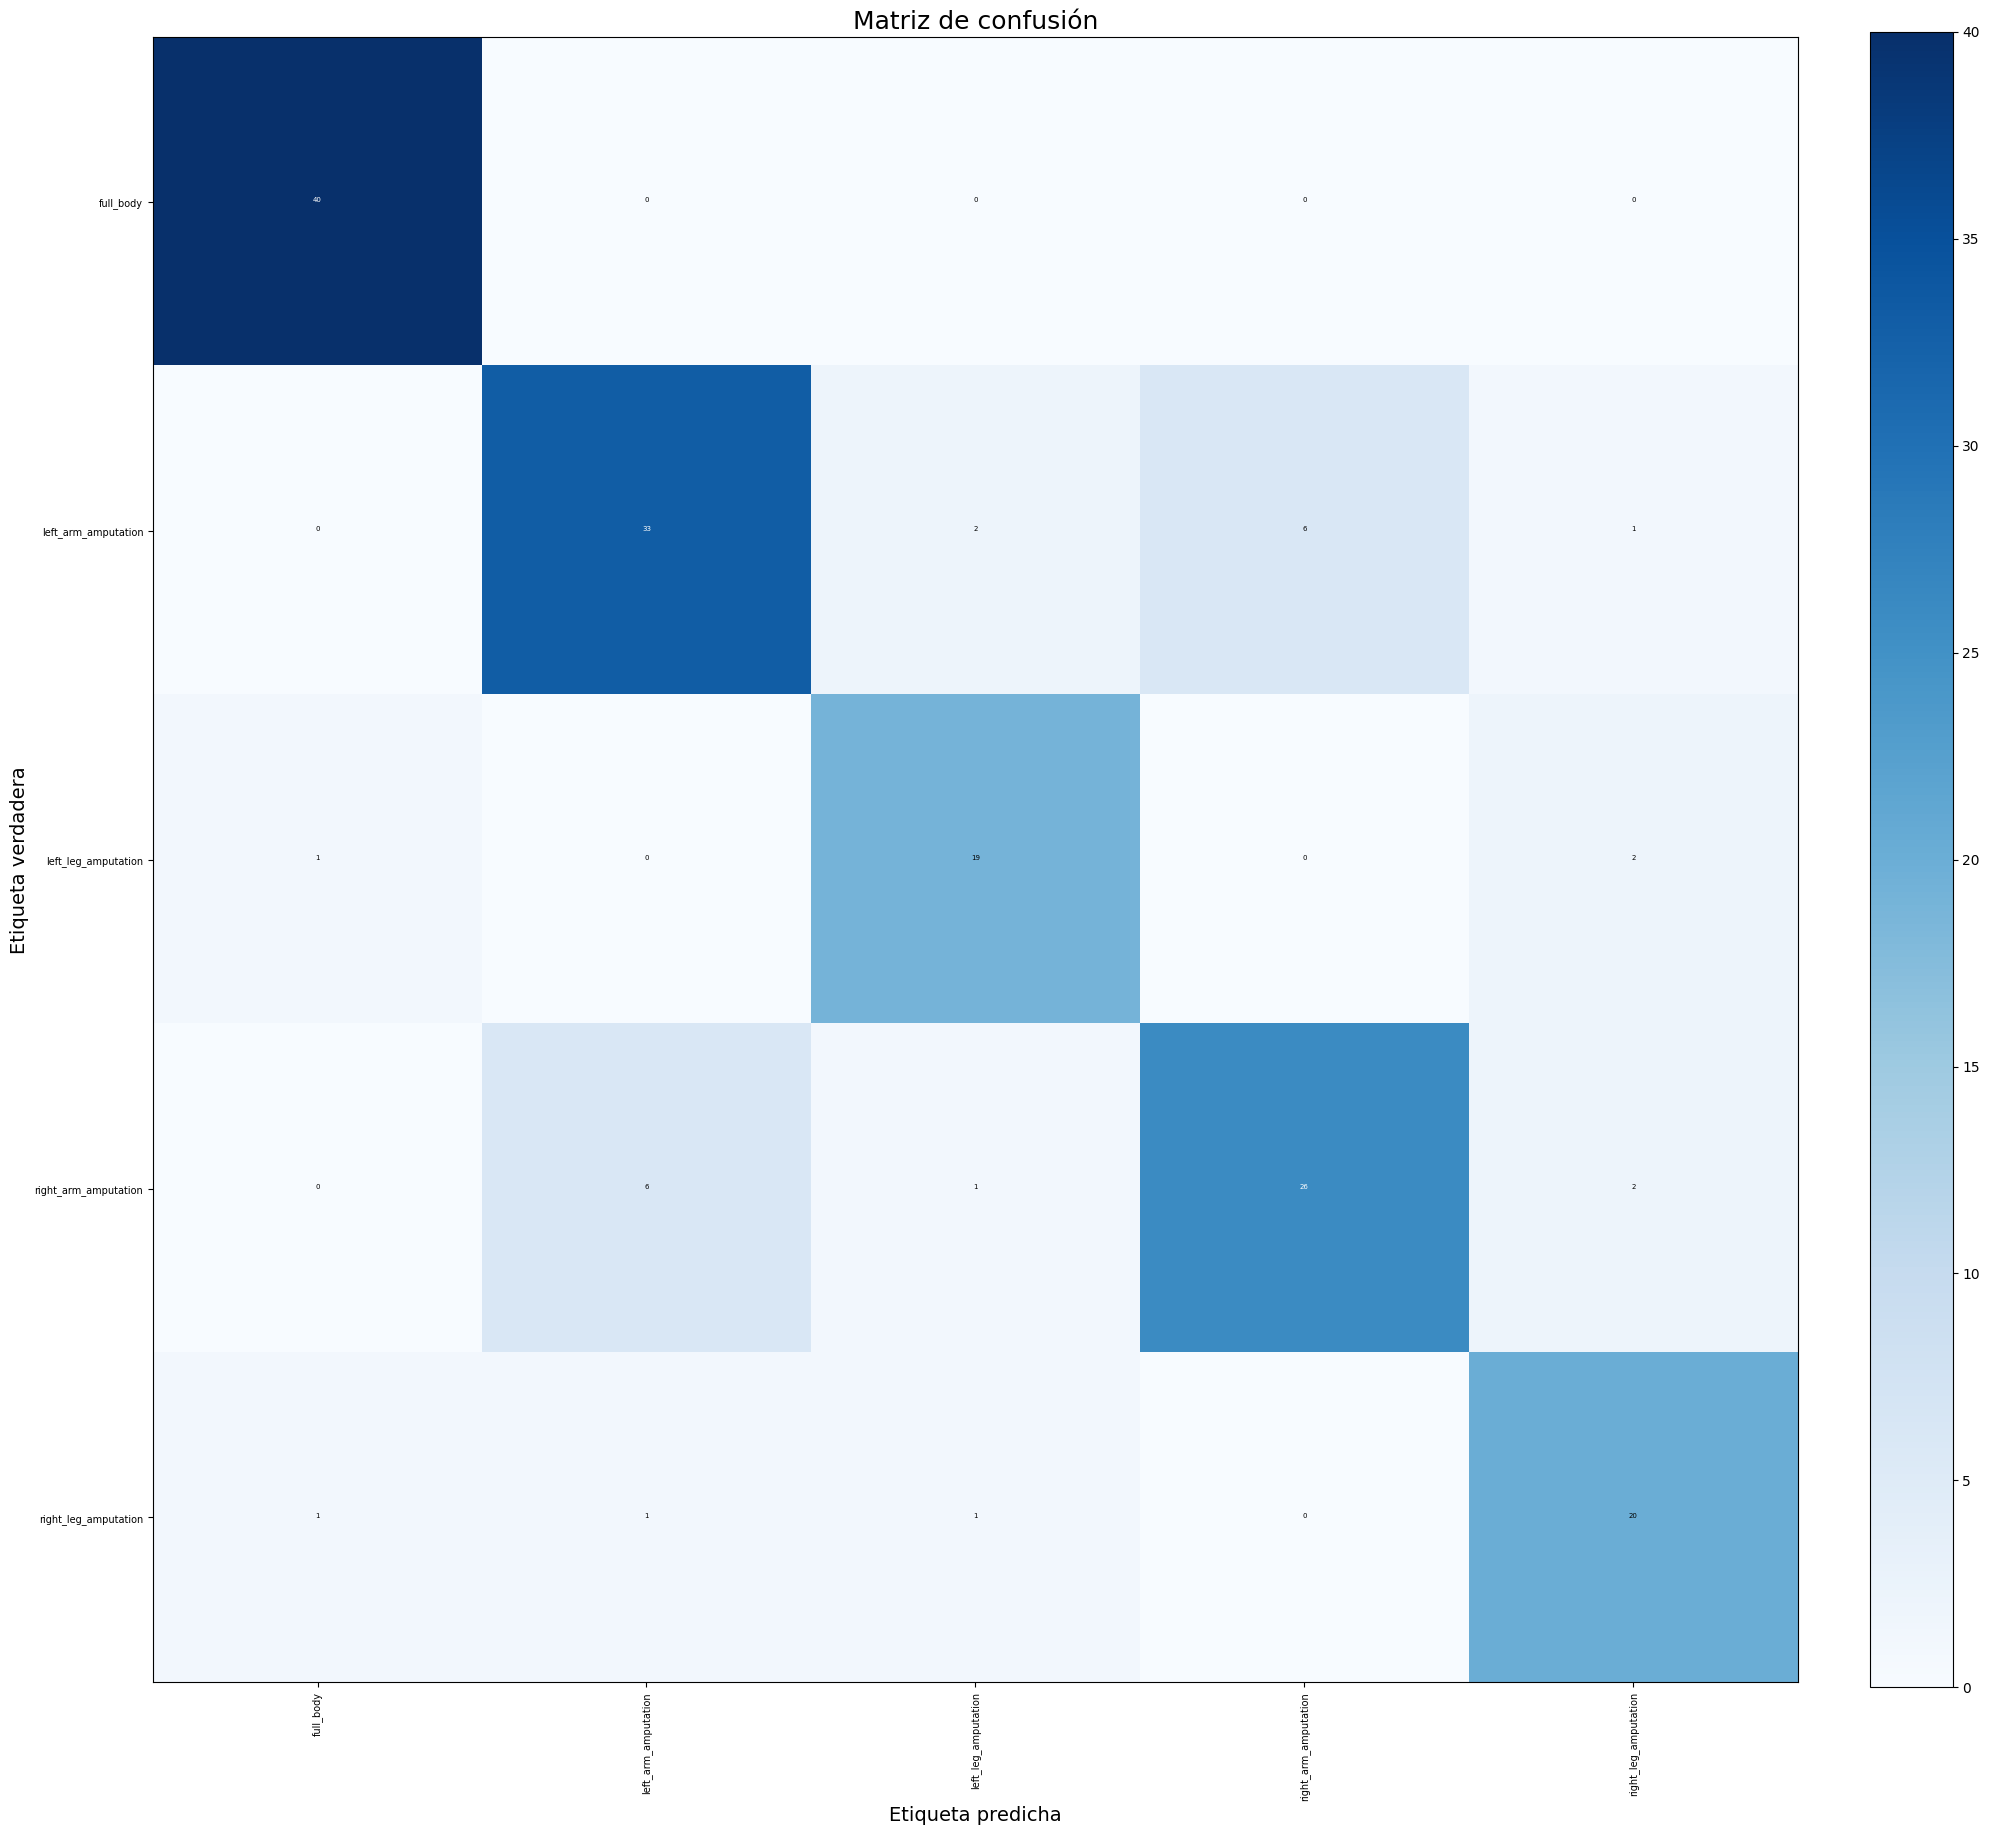


📋 Reporte de clasificación:

                      precision    recall  f1-score   support

           full_body       0.95      1.00      0.98        40
 left_arm_amputation       0.82      0.79      0.80        42
 left_leg_amputation       0.83      0.86      0.84        22
right_arm_amputation       0.81      0.74      0.78        35
right_leg_amputation       0.80      0.87      0.83        23

            accuracy                           0.85       162
           macro avg       0.84      0.85      0.85       162
        weighted avg       0.85      0.85      0.85       162



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, classification_report

# ======== 1. Obtener predicciones ==========
y_pred_probs = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# ======== 2. Matriz de confusión ==========
cm = confusion_matrix(y_true, y_pred)

# ======== 3. Usar nombres reales de las clases ==========
class_names = categories  # ← ya los tienes definidos

# ======== 4. Función para graficar ==========
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matriz de confusión',
                          cmap=plt.cm.Blues,
                          show_text=False):
    fig, ax = plt.subplots(figsize=(20, 20))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title, fontsize=18)
    fig.colorbar(im, fraction=0.046, pad=0.04)

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes, rotation=90, fontsize=7)
    ax.set_yticklabels(classes, fontsize=7)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if show_text:
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            text = f"{cm[i, j]:.2f}" if normalize else f"{cm[i, j]}"
            ax.text(j, i, text,
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=5)

    ax.set_ylabel('Etiqueta verdadera', fontsize=14)
    ax.set_xlabel('Etiqueta predicha', fontsize=14)
    plt.tight_layout()
    plt.grid(False)
    plt.show()

# ======== 5. Mostrar matriz de confusión ========
plot_confusion_matrix(cm, classes=class_names, normalize=False, show_text=True)

# ======== 6. Reporte de clasificación ==========
print("\n📋 Reporte de clasificación:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


In [ ]:
!wget https://assets.change.org/photos/3/vg/rn/fyVgrNtobIDsLkw-800x450-noPad.jpg?1509385581

--2025-06-25 05:28:48--  https://assets.change.org/photos/3/vg/rn/fyVgrNtobIDsLkw-800x450-noPad.jpg?1509385581
Resolving assets.change.org (assets.change.org)... 104.17.89.51, 104.17.88.51
Connecting to assets.change.org (assets.change.org)|104.17.89.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33959 (33K) [image/jpeg]
Saving to: ‘fyVgrNtobIDsLkw-800x450-noPad.jpg?1509385581’

fyVgrNtobIDsLkw-800 100%[===================>]  33.16K  --.-KB/s    in 0.01s   

2025-06-25 05:28:48 (2.91 MB/s) - ‘fyVgrNtobIDsLkw-800x450-noPad.jpg?1509385581’ saved [33959/33959]



1/1 [==============================] - 1s 1s/step


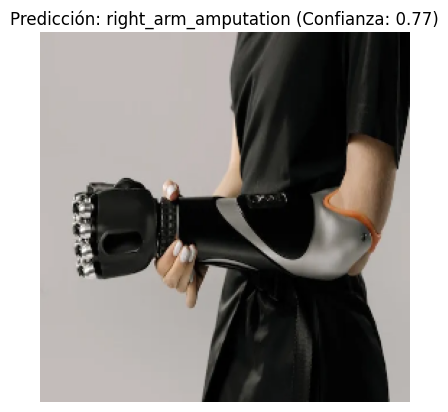

In [ ]:
# prompt: pruebe el modelo con la imagen prueba.png

import matplotlib.pyplot as plt
import numpy as np

# Carga la imagen de prueba
img_path_test = '/content/prueba.png'
img_test = cv2.imread(img_path_test)
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
img_test = cv2.resize(img_test, (img_size, img_size))
img_test = np.expand_dims(img_test, axis=0) # Añadir dimensión de batch

# Realiza la predicción
predictions = model.predict(img_test)

# Obtiene la clase predicha y la confianza
predicted_class_index = np.argmax(predictions, axis=1)[0]
predicted_class_name = categories[predicted_class_index]
confidence = np.max(predictions)

# Muestra la imagen y la predicción
plt.imshow(img_test[0].astype(np.uint8))
plt.title(f"Predicción: {predicted_class_name} (Confianza: {confidence:.2f})")
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 93ms/step


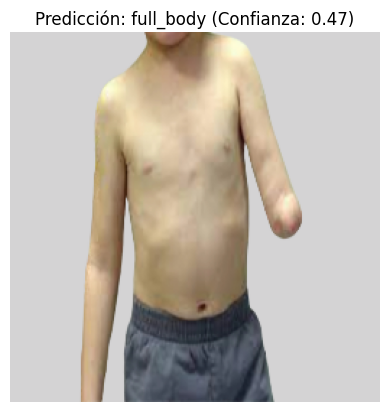

In [ ]:
# prompt: pruebe el modelo con la imagen prueba.png

import matplotlib.pyplot as plt
import numpy as np

# Carga la imagen de prueba
img_path_test = '/content/prueba2.png'
img_test = cv2.imread(img_path_test)
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
img_test = cv2.resize(img_test, (img_size, img_size))
img_test = np.expand_dims(img_test, axis=0) # Añadir dimensión de batch

# Realiza la predicción
predictions = model.predict(img_test)

# Obtiene la clase predicha y la confianza
predicted_class_index = np.argmax(predictions, axis=1)[0]
predicted_class_name = categories[predicted_class_index]
confidence = np.max(predictions)

# Muestra la imagen y la predicción
plt.imshow(img_test[0].astype(np.uint8))
plt.title(f"Predicción: {predicted_class_name} (Confianza: {confidence:.2f})")
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 229ms/step


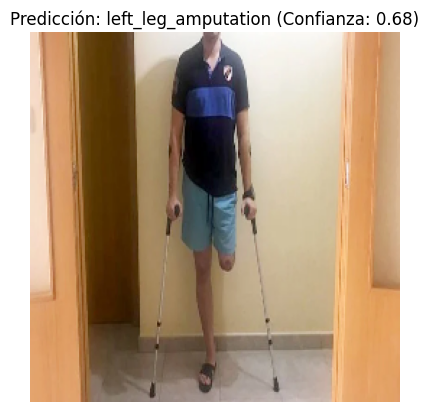

In [ ]:
# prompt: pruebe el modelo con la imagen prueba.png

import matplotlib.pyplot as plt
import numpy as np

# Carga la imagen de prueba
img_path_test = '/content/prueba3.png'
img_test = cv2.imread(img_path_test)
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
img_test = cv2.resize(img_test, (img_size, img_size))
img_test = np.expand_dims(img_test, axis=0) # Añadir dimensión de batch

# Realiza la predicción
predictions = model.predict(img_test)

# Obtiene la clase predicha y la confianza
predicted_class_index = np.argmax(predictions, axis=1)[0]
predicted_class_name = categories[predicted_class_index]
confidence = np.max(predictions)

# Muestra la imagen y la predicción
plt.imshow(img_test[0].astype(np.uint8))
plt.title(f"Predicción: {predicted_class_name} (Confianza: {confidence:.2f})")
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 129ms/step


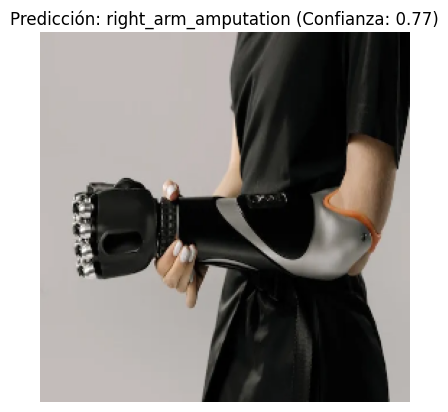

In [ ]:
# prompt: pruebe el modelo con la imagen prueba.png

import matplotlib.pyplot as plt
import numpy as np

# Carga la imagen de prueba
img_path_test = '/content/prueba4.png'
img_test = cv2.imread(img_path_test)
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
img_test = cv2.resize(img_test, (img_size, img_size))
img_test = np.expand_dims(img_test, axis=0) # Añadir dimensión de batch

# Realiza la predicción
predictions = model.predict(img_test)

# Obtiene la clase predicha y la confianza
predicted_class_index = np.argmax(predictions, axis=1)[0]
predicted_class_name = categories[predicted_class_index]
confidence = np.max(predictions)

# Muestra la imagen y la predicción
plt.imshow(img_test[0].astype(np.uint8))
plt.title(f"Predicción: {predicted_class_name} (Confianza: {confidence:.2f})")
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 85ms/step


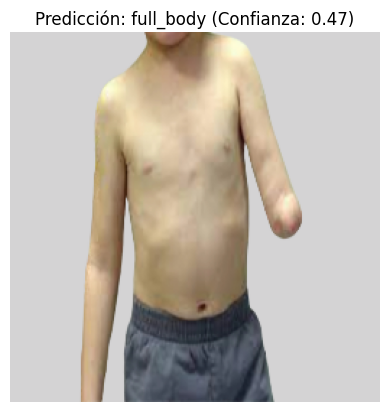

In [ ]:
# prompt: pruebe el modelo con la imagen prueba.png

import matplotlib.pyplot as plt
import numpy as np

# Carga la imagen de prueba
img_path_test = '/content/prueba5.png'
img_test = cv2.imread(img_path_test)
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
img_test = cv2.resize(img_test, (img_size, img_size))
img_test = np.expand_dims(img_test, axis=0) # Añadir dimensión de batch

# Realiza la predicción
predictions = model.predict(img_test)

# Obtiene la clase predicha y la confianza
predicted_class_index = np.argmax(predictions, axis=1)[0]
predicted_class_name = categories[predicted_class_index]
confidence = np.max(predictions)

# Muestra la imagen y la predicción
plt.imshow(img_test[0].astype(np.uint8))
plt.title(f"Predicción: {predicted_class_name} (Confianza: {confidence:.2f})")
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 130ms/step


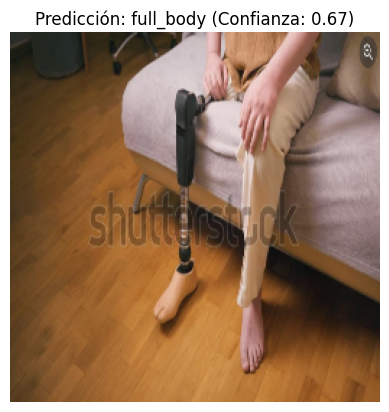

In [ ]:
# prompt: pruebe el modelo con la imagen prueba.png

import matplotlib.pyplot as plt
import numpy as np

# Carga la imagen de prueba
img_path_test = '/content/prueba6.jpg'
img_test = cv2.imread(img_path_test)
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
img_test = cv2.resize(img_test, (img_size, img_size))
img_test = np.expand_dims(img_test, axis=0) # Añadir dimensión de batch

# Realiza la predicción
predictions = model.predict(img_test)

# Obtiene la clase predicha y la confianza
predicted_class_index = np.argmax(predictions, axis=1)[0]
predicted_class_name = categories[predicted_class_index]
confidence = np.max(predictions)

# Muestra la imagen y la predicción
plt.imshow(img_test[0].astype(np.uint8))
plt.title(f"Predicción: {predicted_class_name} (Confianza: {confidence:.2f})")
plt.axis('off')
plt.show()

#Resultado